In [4]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.special import digamma
%matplotlib inline
from ct_charachterization.utility.utils import central_gamma_pdf
from glob import glob
import pydicom as dicom
import dicom_numpy
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.stats import mode

In [98]:
def _get_array_from_mhd_raw_file(path):
    ds = sitk.ReadImage(path)
    image = sitk.GetArrayFromImage(ds)
    return image
def broadcast_3d_tile(matrix, h, w, d):
    m, n, o = matrix.shape[0] * h, matrix.shape[1] * w, matrix.shape[2] * d
    return np.broadcast_to(matrix.reshape(matrix.shape[0], 1, matrix.shape[1], 1, matrix.shape[2], 1),
                           (matrix.shape[0], h, matrix.shape[1], w, matrix.shape[2], d)).reshape(m, n, o)

In [68]:
path = f'''/Users/mostafa/Desktop/dsb_analyse/input/subset0'''
file_path = f'{path}/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd'
img = _get_array_from_mhd_raw_file(path=file_path)
print(img.shape)

(133, 512, 512)


I try to fit a rectangle on a slice of the 3d image. 

Also, I want each axis of the rectangle to be dividable to 35, 35 will be the size of each neighborhood for our image.

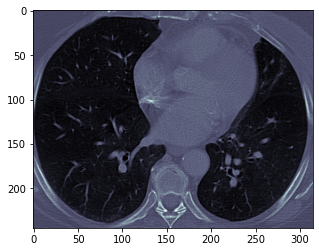

(245, 315)
Is it dividable to the neighborhoods size? True
-1024 -362.0585293164885 1794


In [105]:
data = img[70, 130:375, 115:430]
plt.imshow(data, cmap=plt.cm.bone)
plt.show()
print(data.shape)
print(f'Is it dividable to the neighborhoods size? {(data.shape[0] % 35 == 0) and (data.shape[1] % 35 == 0)}')
print(np.min(data), np.mean(data), np.max(data))

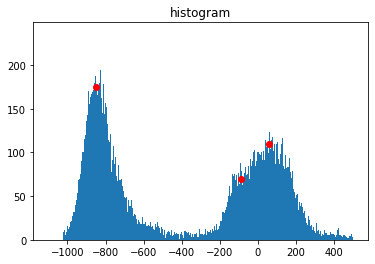

(245, 315)
-1024 -362.0585293164885 1794


In [106]:
flat = data.flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
ax.plot(-850, 175, "or")
ax.plot(-90, 70, "or")
ax.plot(60, 110, "or")
# ax.plot(310, 120, "or")
plt.title("histogram")
plt.show()
print(data.shape)
print(np.min(data), np.mean(data), np.max(data))

Now I want to check the mode of the data:

In [107]:
print(mode(data, axis=None))

ModeResult(mode=array([-1024], dtype=int16), count=array([237]))


I wonder where these values (modes) are!
I want to replace their values with some big number to brighten the relating voxels in the image.
Let's see:

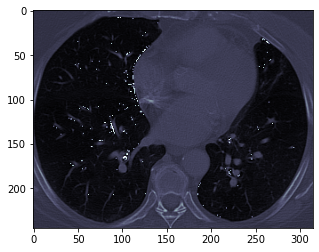

In [108]:
plt.imshow(np.where(data==-1024, 3000, data) , cmap=plt.cm.bone)
plt.show()

OK, According to the histogram, let's define our MU for J = 3 components:

In [109]:
MU = np.array([-850, -90, 60])
J = len(MU)

C = 10
delta = -1025.0
y = data - delta
MU = MU - delta


# initial guess of parameters
# we assume that theta[0] = phi, theta[1] = alpha, theta[2] = beta
shape_of_theta = (3, J)
theta = np.zeros(shape=shape_of_theta)
theta[:, :] = np.array(
    [[1 / J] * J, [2] * J, [MU[j] / 2 for j in range(J)]])
# Eq. 18
shape_of_gamma = tuple(list(y.shape) + [J])
gamma = np.zeros(shape=shape_of_gamma)
for j in range(J):
    gamma[:, :, j] = theta[0, j] * central_gamma_pdf(y, alpha=theta[1, j], beta=theta[2, j])
summation = np.expand_dims(np.sum(gamma, axis=2), axis=-1)
gamma = gamma / summation

In [110]:
max_iter = 10
tol = 0.00000001
err = np.Infinity
n = 0
while err > tol and n < max_iter:
    n += 1
    first_form_summation = np.sum(gamma * (np.expand_dims(y, axis=-1) / MU), axis=(0, 1)).reshape(J)
    second_form_summation = np.sum(gamma * np.log(np.expand_dims(y, axis=-1) / MU), axis=(0, 1)).reshape(J)
    denominator_summation = np.sum(gamma, axis=(0, 1)).reshape(J)
    right_hand_side = (first_form_summation - second_form_summation) / denominator_summation - 1
    to_be_found = lambda alp: right_hand_side - (np.log(alp) - digamma(alp))
    alpha_initial_guess = theta[1, :]
    alpha_solution = fsolve(to_be_found, alpha_initial_guess)
    new_alpha = alpha_solution
    new_beta = np.array(MU) / new_alpha
    new_phi = denominator_summation / y.size
    new_theta = np.array([new_phi, new_alpha, new_beta])
    # Eq. 18
    shape_of_gamma = gamma.shape
    new_gamma = np.zeros(shape=shape_of_gamma)
    for j in range(J):
        new_gamma[:, :, j] = theta[0, j] * central_gamma_pdf(y, alpha=theta[1, j], beta=theta[2, j])
    summation = np.expand_dims(np.sum(new_gamma, axis=2), axis=-1)
    new_gamma = new_gamma / summation
    err = np.linalg.norm(new_theta - theta) / np.linalg.norm(theta)
    theta = new_theta
    gamma = new_gamma
    print('iteration:', n)
    print('error:', err)

iteration: 1
error: 0.34304897666646167
iteration: 2
error: 8.00896625527919e-11


In [111]:
form_of_first_mini_sclm = np.sum(np.sqrt(np.sqrt(np.expand_dims(y, axis=-1)) * gamma) * gamma, axis=(0, 1)).reshape(
    (1, 1, J))
form_of_second_mini_sclm = np.sum(np.sqrt(np.expand_dims(y, axis=-1) * gamma) * gamma, axis=(0, 1)).reshape((1, 1, J))
denominator_summation = np.sum(gamma, axis=(0, 1)).reshape((1, 1, J))
first_mini_sclm = form_of_first_mini_sclm / denominator_summation
second_mini_sclm = form_of_second_mini_sclm / denominator_summation
first_sclm = np.sum(broadcast_3d_tile(first_mini_sclm, y.shape[0], y.shape[1], 1) * theta[0, :], axis=2)
second_sclm = np.sum(broadcast_3d_tile(second_mini_sclm, y.shape[0], y.shape[1], 1) * theta[0, :], axis=2)
var_of_radical_y = second_sclm - np.power(first_sclm, 2)
stable_y = C * (np.sqrt(y) - first_sclm) / np.sqrt(var_of_radical_y) + second_sclm

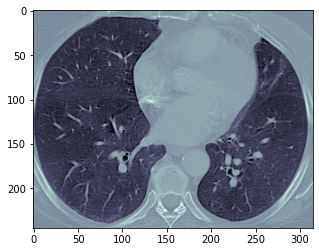

6.592678747362829 106.46584635476152 234.7715196078813


In [112]:
plt.imshow(stable_y, cmap=plt.cm.bone)
plt.show()
print(np.min(stable_y), np.mean(stable_y), np.max(stable_y))